In [1]:
# code for data science project #1
# arthur: Zhongheng Shen, Tianyu Ren, Hongyi Wu
# Oct, 2019
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import copy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("project_data.csv")

## Data Cleaning

In [5]:
# use the trader column as index
# then delete trader column
data.index = data.iloc[:, 0]
del data["Trader ID #"]

In [6]:
# convert all abnormal cells to NaN
def dataclean(x):
    
    try:
        x = float(x)
        if abs(x)<2: # return should be less than 1
            return x
        else:
            return np.nan
    except:
        return np.nan


data = data.applymap(dataclean)

In [7]:
asset=[1,2,3,4,5]
def meanFill(data):
  for i in asset:
    A = [True if 'A'+str(i) in x else False for x in data.columns]
    data[data.columns[A]] = data[data.columns[A]].T.apply(lambda x:x.fillna(np.mean(x))).T
  return data
  
data = meanFill(data)

In [8]:
# normalize by asset to remove market's effect 
def normalize(col):
    mean = np.mean(col[~col.isna()])
    std = np.std(col[~col.isna()])
    return (col - mean) / std
    
    

In [9]:
data_norm = data.apply(normalize)

In [10]:
data_norm

,A1 Month #1,A2 Month #1,A3 Month #1,A4 Month #1,A5 Month #1,Mean Month #1,A1 Month #2,A2 Month #2,A3 Month #2,A4 Month #2,...,A3 Month #20,A4 Month #20,A5 Month #20,Mean Month #20,A1 Month #21,A2 Month #21,A3 Month #21,A4 Month #21,A5 Month #21,Mean Month #21
Trader ID #,,,,,,,,,,,,,,,,,,,,,
1,1.234104,2.267492,1.679950,1.245105,2.071731,0.822649,1.060895,1.850116,1.837656,1.150368,...,2.268191,1.026571,0.429676,0.996098,1.162583,0.378925,1.835558,2.325986,2.058628,2.317108
2,1.234104,1.178045,0.617893,1.113264,1.029125,0.468383,1.519257,1.177804,2.566652,1.150368,...,2.268191,0.701641,1.431317,1.206894,0.468912,0.139498,0.760107,0.794315,1.457886,1.053408
3,0.857504,0.996471,0.769616,0.322222,2.071731,0.468383,1.060895,1.850116,2.019905,1.624208,...,1.574302,1.026571,1.230989,0.996098,0.237688,0.139498,0.760107,2.155800,1.257639,1.369333
4,1.422404,0.633322,1.528228,1.245105,0.731237,0.556950,0.831715,0.953700,2.566652,0.913449,...,1.805598,1.513967,0.630004,1.206894,2.087479,0.857779,0.329926,2.155800,0.656897,2.001183
5,1.234104,1.359620,0.769616,-0.073299,0.731237,0.291250,1.060895,-0.390923,2.748902,1.387288,...,-0.044773,0.864106,1.831973,0.996098,0.237688,0.378925,0.114836,1.475058,1.257639,1.053408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,-0.648897,-0.319945,-0.935030,-1.267618,-0.679349,NaN,-4.439441,0.281388,0.926410,-2.166509,...,-0.276070,-1.410406,-0.571964,-0.901059,-2.305774,-3.212481,-0.100254,-0.396985,-0.144092,-1.789917
646,-0.150456,-0.520211,-1.318798,-1.244352,-0.413769,NaN,-0.085008,0.281388,-0.349334,-1.455750,...,-0.044773,-1.735337,-0.772293,-0.901059,-2.536998,-2.733627,-1.605885,-0.737356,-0.344339,-2.421767
647,-0.482750,-0.659062,-0.979654,-1.011693,-0.626780,NaN,-1.460092,-0.615027,-2.171826,1.150368,...,-1.201256,-1.085476,0.429676,-0.901059,-2.305774,-1.297065,-0.745524,-0.737356,-2.146564,-2.105842


## Data Visualization

In [11]:
asset_list = ['A1', 'A2', 'A3','A4', 'A5']
asset_dict = dict()
#asset_df = pd.DataFrame()
for asset in asset_list:
  A = [True if asset in x else False for x in data.columns]
  asset_dict[asset] = list(data[data.columns[A]].mean())
  #asset_df = pd.concat([asset_df, pd.DataFrame(data[data.columns[A]].mean()).T])
  # asset_df = pd.concat([asset_df, pd.DataFrame(data[data.columns[A]].mean())])
  # asset_A_mean = data_norm[data_norm.columns[A]].mean(axis = 0, skipna = True)
  # print(asset_A_mean)
asset_df = pd.DataFrame(asset_dict)



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


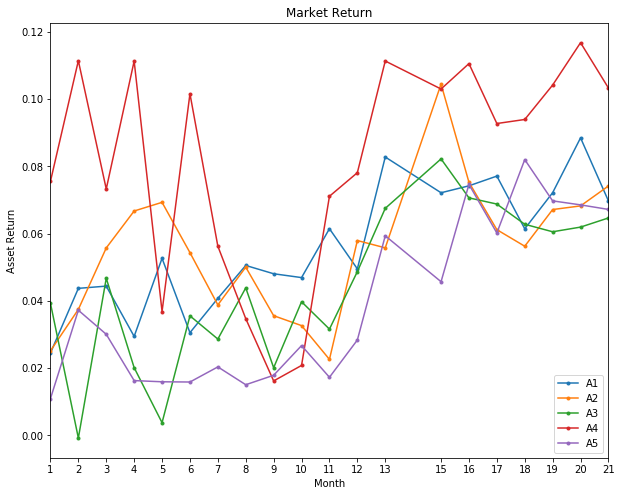

<Figure size 432x288 with 0 Axes>

In [12]:
month = [x for x in range(1, 22)]
print(month)
month.pop(13)
asset_df.index = month
ax = asset_df.plot(style = '.-', figsize=(10,8),xticks=asset_df.index)
ax.set_xlabel('Month')
ax.set_ylabel('Asset Return')
ax.set_title("Market Return")
#plt.axvspan(9,12,facecolor='lightgrey')
plt.show()
plt.savefig("market.png")

In [13]:
# generate new features, calculate vol of five assets
def asset_volatility(asset_type):
    A = [True if asset_type in x else False for x in data_norm.columns]
    data_norm_A = data_norm[data_norm.columns[A]]
    A_vol_list = []
    for i in range(0, len(data_norm_A)):
        A_vol_list.append(np.std(data_norm_A.iloc[i, :]))
    return A_vol_list

In [14]:
A1_vol_list = asset_volatility("A1")
A2_vol_list = asset_volatility("A2")
A3_vol_list = asset_volatility("A3")
A4_vol_list = asset_volatility("A4")
A5_vol_list = asset_volatility("A5")

In [15]:
vol_df = pd.DataFrame([A1_vol_list, A2_vol_list, A3_vol_list, A4_vol_list, A5_vol_list]).T

In [16]:
vol_df 

,0,1,2,3,4
0,0.731108,0.586693,0.502372,0.599469,0.566793
1,0.527118,0.673045,0.719217,0.610628,0.715282
2,0.603612,0.633457,0.547120,0.507377,0.596280
3,0.733352,0.519525,0.683818,0.567275,0.603503
4,0.602888,0.672529,0.697867,0.580753,0.705294
...,...,...,...,...,...
644,1.086744,1.035765,1.011766,1.329049,0.832345
645,0.839200,1.035798,0.918931,0.769951,0.672969
646,0.813972,1.247868,0.987900,1.190521,0.861124
647,0.830376,1.118837,0.638269,1.116285,0.941679


## K-Means

In [18]:
km = KMeans(n_clusters=2).fit(vol_df)
km.predict(vol_df)
labels_km = km.labels_

In [21]:
# fig = plt.figure(1, figsize=(7,7))
# ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
# min1_good, max1_good, max2_good = min1[c==1], max1[c==1], max2[c==1]
# min1_bad, max1_bad, max2_bad = min1[c==-1], max1[c==-1], max2[c==-1]
# ax.scatter(min1_good, max1_good, max2_good, c='#74787a')
# ax.scatter(min1_bad, max1_bad, max2_bad, c='#f26b1f')
# ax.set_xlabel("Volmax1")
# ax.set_ylabel("Volmax2")
# ax.set_zlabel("Volmin")
# plt.title("K Means", fontsize=14);

## Isolation Tree

In [22]:
scaler = StandardScaler()
#np_scaled = scaler.fit_transform(vol_df)
#data_vol_scaled = pd.DataFrame
# train isolation forest
outliers_fraction = 0.1
model = IsolationForest(contamination=outliers_fraction)
model.fit(vol_df.iloc[:,0:5]) 
vol_df['anomaly2'] = pd.Series(model.predict(vol_df.iloc[:,0:5]))
#vol_df['iso_score'] = pd.Series(model.score_samples(vol_df.iloc[:, 0:5]))

/Users/shin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/shin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [23]:
vol_df

,0,1,2,3,4,anomaly2
0,0.731108,0.586693,0.502372,0.599469,0.566793,1
1,0.527118,0.673045,0.719217,0.610628,0.715282,1
2,0.603612,0.633457,0.547120,0.507377,0.596280,1
3,0.733352,0.519525,0.683818,0.567275,0.603503,1
4,0.602888,0.672529,0.697867,0.580753,0.705294,1
...,...,...,...,...,...,...
644,1.086744,1.035765,1.011766,1.329049,0.832345,-1
645,0.839200,1.035798,0.918931,0.769951,0.672969,1
646,0.813972,1.247868,0.987900,1.190521,0.861124,-1
647,0.830376,1.118837,0.638269,1.116285,0.941679,-1


In [24]:
good = vol_df[vol_df['anomaly2']==1].index
bad = vol_df[vol_df['anomaly2']==-1].index


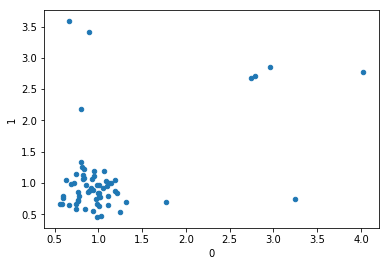

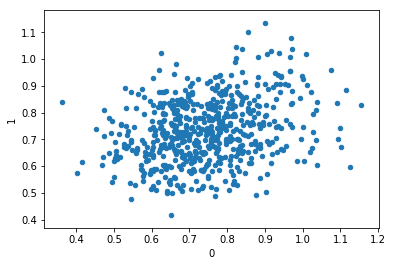

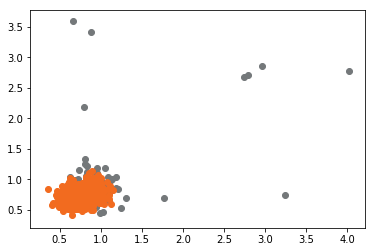

In [26]:
vol_df.loc[bad].iloc[:,0:2].plot.scatter(0,1)
vol_df.loc[good].iloc[:,0:2].plot.scatter(0,1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(vol_df.loc[bad].iloc[:,0], vol_df.loc[bad].iloc[:,1], c='#74787a')
ax.scatter(vol_df.loc[good].iloc[:,0], vol_df.loc[good].iloc[:,1],c='#f26b1f')

In [28]:
vol_df['max1'] = vol_df.iloc[:, 0:5].max(axis=1)
vol_df["min"] = vol_df.iloc[:, 0:5].min(axis=1)
#vol_df['max2'] = vol_df.iloc[:, 0:5].T.apply(lambda x: x.nlargest(2))
def get_second_largest(x):
  return sorted(x)[-2]
vol_df['max2'] = vol_df.iloc[:, 0:5].apply(lambda row: get_second_largest(row), axis = 1)
vol_df['average'] = vol_df.iloc[:, 0:5].mean(axis=1)

In [29]:
vol_df

,0,1,2,3,4,anomaly2,max1,min,max2,average
0,0.731108,0.586693,0.502372,0.599469,0.566793,1,0.731108,0.502372,0.599469,0.597287
1,0.527118,0.673045,0.719217,0.610628,0.715282,1,0.719217,0.527118,0.715282,0.649058
2,0.603612,0.633457,0.547120,0.507377,0.596280,1,0.633457,0.507377,0.603612,0.577569
3,0.733352,0.519525,0.683818,0.567275,0.603503,1,0.733352,0.519525,0.683818,0.621495
4,0.602888,0.672529,0.697867,0.580753,0.705294,1,0.705294,0.580753,0.697867,0.651866
...,...,...,...,...,...,...,...,...,...,...
644,1.086744,1.035765,1.011766,1.329049,0.832345,-1,1.329049,0.832345,1.086744,1.059134
645,0.839200,1.035798,0.918931,0.769951,0.672969,1,1.035798,0.672969,0.918931,0.847370
646,0.813972,1.247868,0.987900,1.190521,0.861124,-1,1.247868,0.813972,1.190521,1.020277
647,0.830376,1.118837,0.638269,1.116285,0.941679,-1,1.118837,0.638269,1.116285,0.929089


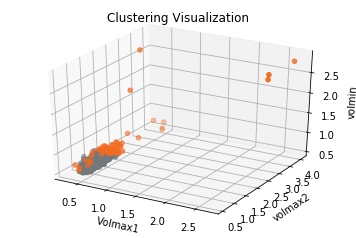

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
max1 = vol_df['max1']
max2 = vol_df['max2']
min1 = vol_df['min']
c = vol_df['anomaly2']
min1_good, max1_good, max2_good = min1[c==1], max1[c==1], max2[c==1]
min1_bad, max1_bad, max2_bad = min1[c==-1], max1[c==-1], max2[c==-1]
ax.scatter(min1_good, max1_good, max2_good, c='#74787a')
ax.scatter(min1_bad, max1_bad, max2_bad, c='#f26b1f')
ax.set_xlabel("Volmax1")
ax.set_ylabel("volmax2")
ax.set_zlabel("volmin")
ax.set_title("Clustering Visualization")
plt.savefig("Isolation Tree")

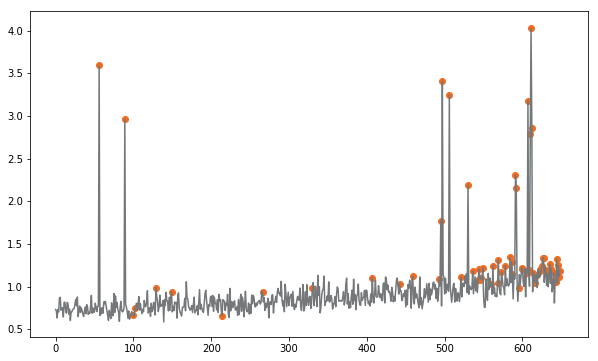

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
a = vol_df.loc[vol_df['anomaly2'] == -1, ['max1']] #anomaly
ax.plot(vol_df.index, vol_df['max1'], color='#74787a')
ax.scatter(a.index,a['max1'], color='#f26b1f')

In [32]:
result_df = vol_df.iloc[:,-6:]

result_df['gap'] = result_df['max1'] - result_df['min']

result_df

,4,anomaly2,max1,min,max2,average,gap
0,0.566793,1,0.731108,0.502372,0.599469,0.597287,0.228736
1,0.715282,1,0.719217,0.527118,0.715282,0.649058,0.192099
2,0.596280,1,0.633457,0.507377,0.603612,0.577569,0.126081
3,0.603503,1,0.733352,0.519525,0.683818,0.621495,0.213827
4,0.705294,1,0.705294,0.580753,0.697867,0.651866,0.124541
...,...,...,...,...,...,...,...
644,0.832345,-1,1.329049,0.832345,1.086744,1.059134,0.496704
645,0.672969,1,1.035798,0.672969,0.918931,0.847370,0.362830
646,0.861124,-1,1.247868,0.813972,1.190521,1.020277,0.433895
647,0.941679,-1,1.118837,0.638269,1.116285,0.929089,0.480568


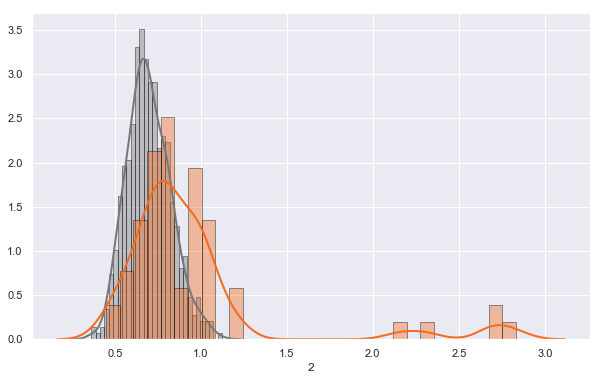

In [33]:
# a = result_df.loc[result_df['anomaly2'] == 1, 'max1']
# b = result_df.loc[result_df['anomaly2'] == -1, 'max1']
# plt.figure(figsize=(10, 6))
# plt.hist(a, bins = 80, alpha=0.5, label='Good Trader')
# plt.hist(b, bins = 80, alpha=0.5, label='Bad Trader')
# plt.legend(loc='upper right')
# plt.xlabel('Max - Min')
# plt.ylabel('Count')
# plt.show();


a = vol_df.loc[result_df['anomaly2'] == 1].iloc[:,2]
b = vol_df.loc[result_df['anomaly2'] == -1].iloc[:,2]

# # plt.figure(figsize=(10, 6))
# # plt.hist(a, bins = 80, alpha=0.5, label='Good Trader')
# # plt.hist(b, bins = 80, alpha=0.5, label='Bad Trader')
# # plt.legend(loc='upper right')
# # plt.xlabel('Maximum Volatility')
# # plt.ylabel('Count')
# # plt.show();
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot(a,hist=True, kde=True,bins=30, color = '#74787a', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
sns.distplot(b,hist=True, kde=True,bins=30, color = '#f26b1f', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})

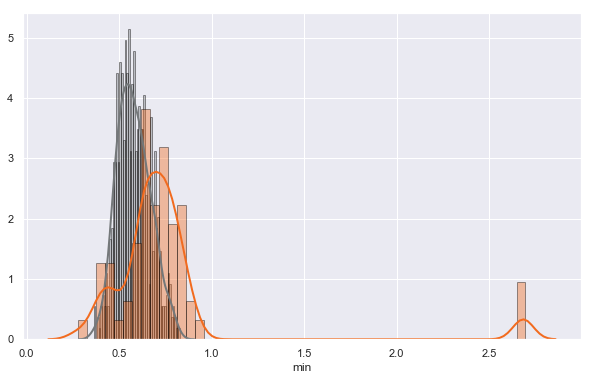

In [34]:
a = result_df.loc[result_df['anomaly2'] == 1, 'min']
b = result_df.loc[result_df['anomaly2'] == -1, 'min']
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot(a,hist=True, kde=True,bins=50, color = '#74787a', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
sns.distplot(b,hist=True, kde=True,bins=50, color = '#f26b1f', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
# plt.figure(figsize=(10, 6))
# plt.hist(a, bins = 50, alpha=0.5, label='Good Trader')
# plt.hist(b, bins = 50, alpha=0.5, label='Bad Trader')
# plt.legend(loc='upper right')
# plt.xlabel('Minimum Volatility')
# plt.ylabel('Count')
# plt.show();

## SVM

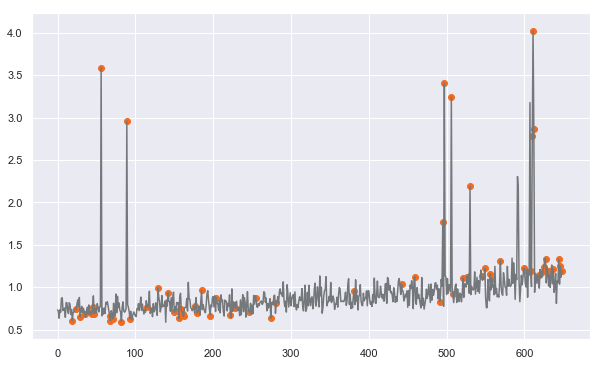

In [38]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(vol_df.iloc[:, 0:2])
data_svm = pd.DataFrame(np_scaled)
# train oneclassSVM
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data_svm)
vol_df['anomaly3'] = pd.Series(model.predict(data_svm))
fig, ax = plt.subplots(figsize=(10,6))
a = vol_df.loc[vol_df['anomaly3'] == -1, ['max1']] #anomaly
ax.plot(vol_df.index, vol_df['max1'], color='#74787a')
ax.scatter(a.index,a['max1'], color='#f26b1f')
plt.show();

In [42]:
result_df_svm = vol_df[['max1', 'min', 'max2', 'anomaly3', 'average']]
result_df_svm['gap'] = result_df_svm['max1'] - result_df_svm['min']
result_df_svm

/Users/shin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,max1,min,max2,anomaly3,average,gap
0,0.731108,0.502372,0.599469,1,0.597287,0.228736
1,0.719217,0.527118,0.715282,1,0.649058,0.192099
2,0.633457,0.507377,0.603612,1,0.577569,0.126081
3,0.733352,0.519525,0.683818,1,0.621495,0.213827
4,0.705294,0.580753,0.697867,1,0.651866,0.124541
...,...,...,...,...,...,...
644,1.329049,0.832345,1.086744,-1,1.059134,0.496704
645,1.035798,0.672969,0.918931,1,0.847370,0.362830
646,1.247868,0.813972,1.190521,-1,1.020277,0.433895
647,1.118837,0.638269,1.116285,1,0.929089,0.480568


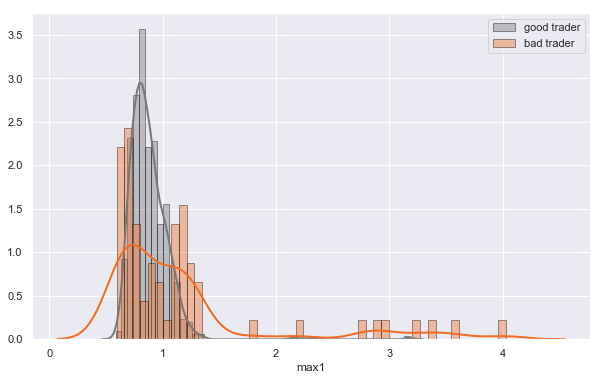

In [43]:
a = result_df_svm.loc[result_df_svm['anomaly3'] == 1, 'max1']
b = result_df_svm.loc[result_df_svm['anomaly3'] == -1, 'max1']
# plt.figure(figsize=(10, 6))
# plt.hist(a, bins = 100, alpha=0.5, label='Good Trader')
# plt.hist(b, bins = 100, alpha=0.5, label='Bad Trader')
# plt.legend(loc='upper right')
# plt.xlabel('Maximum Volatility')
# plt.ylabel('Count')
# plt.show();
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot(a,hist=True, kde=True,bins=50, color = '#74787a', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
sns.distplot(b,hist=True, kde=True,bins=50, color = '#f26b1f', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
plt.legend(labels=['good trader', 'bad trader'])

## Overlapping

In [46]:
overlap_bad_trader_list = list(vol_df.loc[(vol_df['anomaly2'] == -1) & (vol_df['anomaly3'] == -1)].index)

In [47]:
len(overlap_bad_trader_list)

27

In [48]:
overlap_bad_trader_list

[56,
 89,
 129,
 442,
 459,
 495,
 497,
 506,
 521,
 530,
 549,
 569,
 599,
 605,
 608,
 610,
 611,
 612,
 618,
 622,
 625,
 627,
 630,
 637,
 644,
 646,
 648]

## Visualization

In [49]:
def visualize_bad_trader_return(data, trader_id_list, asset_id):
  c = [True if asset_id in x else False for x in data.columns]
  month = list(range(1,22))
  month.remove(14)
  data[data.columns[c]].loc[trader_id_list].T.plot(marker="o")
  plt.show()

  


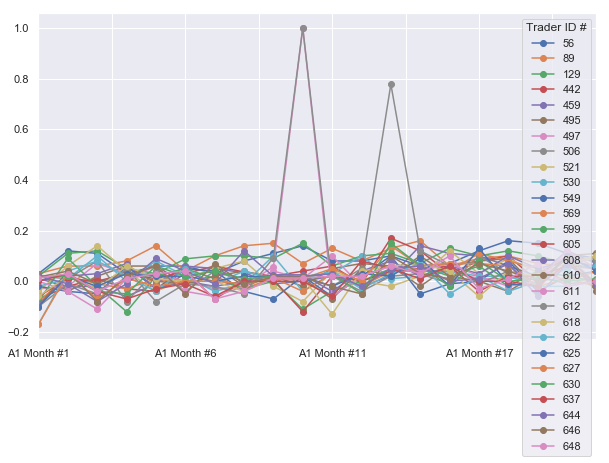

In [50]:
visualize_bad_trader_return(data, overlap_bad_trader_list, 'A1')

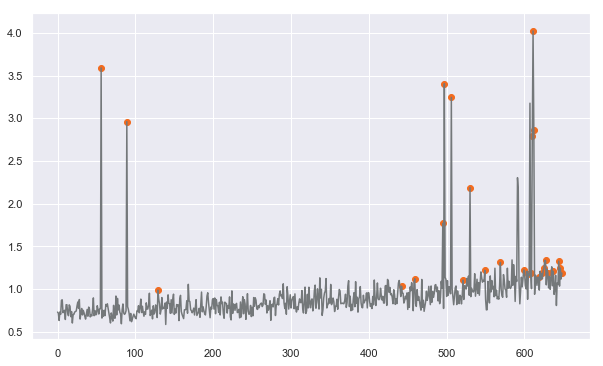

In [51]:
# max volatility
fig, ax = plt.subplots(figsize=(10,6))
a = vol_df.loc[overlap_bad_trader_list] #anomaly
ax.plot(vol_df.index, vol_df['max1'], color='#74787a')

ax.scatter(a.index,a['max1'], color='#f26b1f')

plt.show();

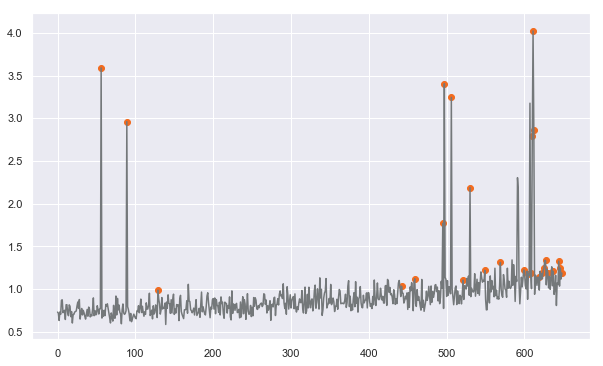

In [52]:
# average
fig, ax = plt.subplots(figsize=(10,6))
overlap_df = vol_df.loc[overlap_bad_trader_list] #anomaly
ax.plot(vol_df.index, vol_df['max1'], color='#74787a')

ax.scatter(overlap_df.index,overlap_df['max1'], color='#f26b1f')

plt.show();

In [61]:
# a = overlap_df['max1']
# both_good_trader_list = list(set(list(data_norm.index)) - set(overlap_bad_trader_list))
# b = vol_df.loc[both_good_trader_list]['max1']
# # plt.figure(figsize=(10, 6))
# # plt.hist(a, bins = 100, alpha=0.5, label='Good Trader')
# # plt.hist(b, bins = 100, alpha=0.5, label='Bad Trader')
# # plt.legend(loc='upper right')
# # plt.xlabel('Maximum Volatility')
# # plt.ylabel('Count')
# # plt.show();
# sns.set(rc={'figure.figsize':(10,6)})
# sns.distplot(b,hist=True, kde=True,bins=50, color = '#74787a', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
# sns.distplot(a,hist=True, kde=True,bins=50, color = '#f26b1f', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
# plt.legend(labels=['good trader', 'bad trader'])

/Users/shin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


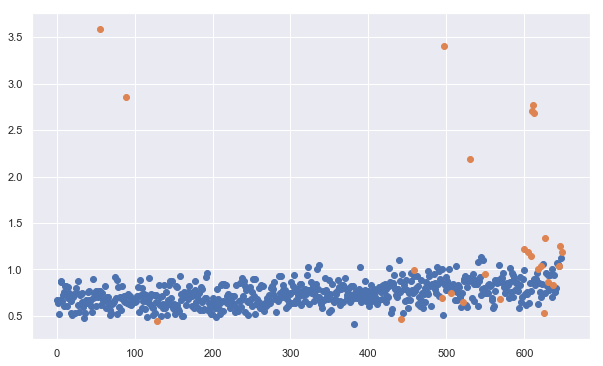

In [54]:
def visualize_good_trader_vol(asset_id):
  
  # a = [True if asset_id in x else False for x in data_norm.co
  plt.scatter(both_good_trader_list, vol_df.iloc[:,asset_id].loc[both_good_trader_list].to_list())
  plt.scatter(overlap_bad_trader_list, vol_df.iloc[:,asset_id].loc[overlap_bad_trader_list].to_list())
visualize_good_trader_vol(1)
#vol_df.iloc[:,0].loc[both_good_trader_list].to_list()

In [57]:
# def compare_good_trader_vol(asset_id):
  
#   # a = [True if asset_id in x else False for x in data_norm.co
#   plt.scatter(vol_df.iloc[:,asset_id].loc[overlap_bad_trader_list].to_list(),vol_df.iloc[:,asset_id].loc[both_good_trader_list].to_list())
#   plt.scatter(vol_df.iloc[:,asset_id].loc[both_good_trader_list].to_list(),vol_df.iloc[:,asset_id].loc[overlap_bad_trader_list].to_list())
# compare_good_trader_vol(1)

In [58]:
# 1vol_df.iloc[:,0].loc[both_good_trader_list]